In [1]:
from google.colab import drive
drive.mount("/content/googleDrive")

!pip install transformers
!pip install keras
!pip install tensorflow
!pip install scikit-learn
!pip install pandas
!pip install boto3

Mounted at /content/googleDrive
     |████████████████████████████████| 3.4 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 64.8 MB/s 
     |████████████████████████████████| 596 kB 74.0 MB/s 
     |████████████████████████████████| 895 kB 74.3 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 131 kB 5.0 MB/s 
     |████████████████████████████████| 79 kB 10.6 MB/s 
     |████████████████████████████████| 8.5 MB 34.7 MB/s 
     |████████████████████████████████| 138 kB 75.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the 

In [2]:
# reference file: src-root/common/components.py

from abc import ABC, abstractmethod


class BaseMixin(ABC):

    @property
    @abstractmethod
    def name(self):
        raise NotImplementedError

    @abstractmethod
    def compile(self, *args, **kwargs):
        raise NotImplementedError

    @abstractmethod
    def train(self, *args, **kwargs):
        raise NotImplementedError

    @abstractmethod
    def predict(self, *args, **kwargs):
        raise NotImplementedError

    @abstractmethod
    def save(self, *args, **kwargs):
        raise NotImplementedError

    @abstractmethod
    def load(self, *args, **kwargs):
        raise NotImplementedError

In [3]:
# reference file: src-root/common/utils.py

import logging
import os.path
import tarfile
import time

import boto3
import pandas


def load_data_from_csv(filepath):
    df = pandas.read_csv(filepath)
    return df.dropna()


def aws_client(service_name, region_name, access_key, secret_key, **opt):
    return boto3.client(
        service_name,
        region_name=region_name,
        aws_access_key_id=access_key,
        aws_secret_access_key=secret_key,
        **opt
    )


def upload_file_to_s3(target_file, object_name, bucket, access_key, secret_key, region, **opt):
    s3 = aws_client("s3", region, access_key, secret_key, **opt)
    with open(target_file, "rb") as f:
        s3.upload_fileobj(f, bucket, object_name)


def download_file_from_s3(target_file, object_name, bucket, access_key, secret_key, region, **opt):
    s3 = aws_client("s3", region, access_key, secret_key, **opt)
    with open(target_file, "wb") as f:
        s3.download_fileobj(bucket, object_name, f)


def make_tarfile(tar_filepath, source_dir):
    with tarfile.open(tar_filepath, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))


def extract_tarfile(extract_dir, tar_filepath):
    with tarfile.open(tar_filepath, "r:gz") as tar:
        tar.extractall(extract_dir)


def prerequisites_check__state_is_true(state):
    try:
        assert state is True
    except AssertionError:
        raise RuntimeError("State must be TRUE!")


def aspect_logging(func):
    log = logging.getLogger()

    def wrap(*args, **kwargs):
        start = time.time()
        log.info("Start: %s." % func.__name__)
        ret = func(*args, **kwargs)
        end = time.time()
        log.info("End: %s, elapsed: %s." % (func.__name__, end - start))
        return ret

    return wrap

In [4]:
# reference file: src-root/models/qna_classification_model.py

import os
import uuid

import keras
import numpy
import tensorflow as tf
import transformers
from keras.layers import Input, Dropout, Dense
from keras.models import Model
from keras.utils.np_utils import to_categorical
from pandas import Categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import TFBertModel, BertTokenizer, BertConfig 

log = logging.getLogger()
log.addHandler(logging.StreamHandler())
log.setLevel(logging.INFO)

log.info("Using tf: v.%s, transformers: v.%s, keras: v.%s." % (
    tf.__version__, transformers.__version__, keras.__version__))


class Const:
    BERT_NAME = "bert-base-multilingual-cased"
    BERT_BATCH_SIZE_TABLE = {
        64: 64,
        128: 32,
        256: 16,
        320: 14,
        384: 12,
        512: 6
    }
    MAX_LENGTH_LIST = BERT_BATCH_SIZE_TABLE.keys()
    TEMP_DIR = ".tmp"


class QnaContentsClassifier(BaseMixin):
    __slots__ = (
        "uid", "max_length", "num_classes", "dropout_rate", "epochs",
        "aws_s3", "device", "bert_config", "bert_tokenizer", "bert_model", "model",
        "fit_result", "eval_result"
    )

    def __init__(self, context=None):
        super().__init__()
        os.makedirs(Const.TEMP_DIR, mode=0o744, exist_ok=True)

        self.uid = uuid.uuid4().hex
        self.max_length = 128
        self.num_classes = 5
        self.dropout_rate = 0.3
        self.epochs = 10
        self.aws_s3 = {}

        if context is not None:
            self.uid = context.uid
            self.aws_s3 = context.conf.get_or_default("aws.s3", {})

            if hasattr(context.params, "max_length"):
                self.max_length = int(context.params.max_length)
                prerequisites_check__state_is_true(self.max_length in Const.MAX_LENGTH_LIST)

            if hasattr(context.params, "num_classes"):
                self.num_classes = int(context.params.num_classes)
                prerequisites_check__state_is_true(self.num_classes > 1)

            if hasattr(context.params, "dropout_rate"):
                self.dropout_rate = float(context.params.dropout_rate)
                prerequisites_check__state_is_true(0 < self.dropout_rate < 1)

            if hasattr(context.params, "epochs"):
                self.epochs = int(context.params.epochs)
                prerequisites_check__state_is_true(self.epochs > 0)

        self.device = tf.config.list_logical_devices().pop(0).name
        gpus = tf.config.list_logical_devices("GPU")
        if len(gpus) > 0:  # check available GPU
            self.device = gpus.pop(0).name
        log.info("Device: %s." % self.device)

        self.bert_config = BertConfig.from_pretrained(Const.BERT_NAME)
        self.bert_tokenizer = BertTokenizer.from_pretrained(Const.BERT_NAME, config=self.bert_config)
        self.bert_model = TFBertModel.from_pretrained(Const.BERT_NAME, config=self.bert_config)
        log.info("Pre-trained BERT: %s." % Const.BERT_NAME)

        self.model = None
        self.fit_result = None
        self.eval_result = None

    @property
    def name(self):
        return "QnaContentsClassifier"

    @aspect_logging
    def compile(self, max_length=None, num_classes=None, dropout_rate=None):
        max_length = max_length if max_length is not None else self.max_length
        num_classes = num_classes if num_classes is not None else self.num_classes
        dropout_rate = dropout_rate if dropout_rate is not None else self.dropout_rate

        prerequisites_check__state_is_true(max_length in Const.MAX_LENGTH_LIST)
        prerequisites_check__state_is_true(num_classes > 1)
        prerequisites_check__state_is_true(0 < dropout_rate < 1)

        inputs = {
            "input_ids": Input(shape=(max_length,), dtype="int32"),
            "token_type_ids": Input(shape=(max_length,), dtype="int32"),
            "attention_mask": Input(shape=(max_length,), dtype="int32"),
        }
        main_layer = self.bert_model  # load main layer
        if main_layer.trainable is True:
            main_layer.trainable = False  # freeze main layer

        pooled_output = main_layer(inputs).pooler_output
        dropout = Dropout(dropout_rate, name="pooled_output")(pooled_output, training=False)
        outputs = Dense(num_classes, name="classifier", activation="softmax")(dropout)

        model = Model(inputs=inputs, outputs=outputs, name=self.name)
        model.compile(
            optimizer="adam",
            loss="categorical_crossentropy",
            metrics=[
                "categorical_accuracy",
            ]
        )
        self.model = model
        self.model.summary()
        return self

    @aspect_logging
    def train(self, dataset, max_length=None, num_classes=None, epochs=None, *, mode):
        max_length = max_length if max_length is not None else self.max_length
        num_classes = num_classes if num_classes is not None else self.num_classes
        epochs = epochs if epochs is not None else self.epochs

        prerequisites_check__state_is_true(max_length in Const.MAX_LENGTH_LIST)
        prerequisites_check__state_is_true(num_classes > 1)
        prerequisites_check__state_is_true(epochs > 0)
        prerequisites_check__state_is_true(mode in ("fit", "eval"))
        prerequisites_check__state_is_true(self.model is not None)

        batch_size = Const.BERT_BATCH_SIZE_TABLE[max_length]

        x = self._embedding_x(dataset.contents.to_list(), max_length)
        y = self._embedding_y(dataset.label.to_list(), num_classes)

        with tf.device(self.device):
            log.info("Mode: %s" % mode)
            if mode == "fit":
                self.fit_result = self.model.fit(x=x, y=y, batch_size=batch_size, epochs=epochs, validation_split=0.2)
            else:
                self.eval_result = self.model.evaluate(x=x, y=y, batch_size=batch_size, return_dict=True)
        return self

    @aspect_logging
    def predict(self, dataset, max_length=None):
        max_length = max_length if max_length is not None else self.max_length

        prerequisites_check__state_is_true(max_length in Const.MAX_LENGTH_LIST)
        prerequisites_check__state_is_true(self.model is not None)

        ret = None
        for _ in tqdm(range(1)):
            with tf.device(self.device):
                ret = self.model.predict(self._embedding_x(dataset.contents.to_list(), max_length))
        return ret

    @aspect_logging
    def save(self, storage, compression=False, delete_save_file=False):
        prerequisites_check__state_is_true(self.model is not None)
        prerequisites_check__state_is_true(storage in ("disk", "s3"))

        model_file_path = os.path.join(Const.TEMP_DIR, self.name + "-" + self.uid + ".h5")
        log.info("Save weights: %s." % model_file_path)
        for _ in tqdm(range(1)):
            self.model.save_weights(model_file_path)

        if compression is True:  # .tar.gz
            tar_file_path = os.path.join(Const.TEMP_DIR, self.name + "-" + self.uid + ".tar.gz")
            log.info("Compression: %s." % tar_file_path)
            for _ in tqdm(range(1)):
                make_tarfile(tar_file_path, model_file_path)
                if delete_save_file is True:
                    os.remove(model_file_path)
                model_file_path = tar_file_path

        log.info("Write %s: %s." % (storage, model_file_path))
        if self.aws_s3 and storage == "s3":  # upload s3
            for _ in tqdm(range(1)):
                upload_file_to_s3(model_file_path, os.path.basename(model_file_path), **self.aws_s3)
        elif not self.aws_s3 and storage == "s3":
            raise RuntimeError("Not found s3 configuration.")

        if delete_save_file is True:
            os.remove(model_file_path)
        return self

    @aspect_logging
    def load(self, filepath, storage="disk", delete_load_file=False):
        prerequisites_check__state_is_true(self.model is not None)
        prerequisites_check__state_is_true(storage in ("disk", "s3"))

        filepath = self._download_from_storage(filepath, storage)
        filename, gz = os.path.splitext(filepath)
        filename, tar = os.path.splitext(filename)

        if tar + gz == ".tar.gz":  # is compression file ?
            log.info("Extract: %s." % filepath)
            for _ in tqdm(range(1)):
                extract_tarfile(Const.TEMP_DIR, filepath)
                filepath = os.path.join(Const.TEMP_DIR, os.path.basename(filename) + ".h5")

        if os.path.splitext(filepath)[1] == ".h5" and os.path.exists(filepath):  # only load weights using HDF5 file
            log.info("Load weights: %s." % filepath)
            for _ in tqdm(range(1)):
                with tf.device(self.device):
                    self.model.load_weights(filepath)
        else:
            raise RuntimeError("Not found '.h5' file. input filepath: %s." % filepath)

        if delete_load_file is True:
            os.remove(filepath)
        return self

    @aspect_logging
    def load_dataset(self, filepath, storage="disk", delete_load_file=False, test_size=0.1):
        prerequisites_check__state_is_true(storage in ("disk", "s3"))
        prerequisites_check__state_is_true(os.path.splitext(filepath)[1] == ".csv")
        prerequisites_check__state_is_true(0 < test_size < 1)

        filepath = self._download_from_storage(filepath, storage)
        df = load_data_from_csv(filepath)

        if delete_load_file is True:
            os.remove(filepath)

        if "label" in df:
            df["category"] = Categorical(df["label"])
            df["label"] = df["category"].cat.codes

        return train_test_split(df, test_size=test_size, shuffle=True)

    def _embedding_x(self, contents_list, max_length):
        max_length = max_length if max_length is not None else self.max_length
        prerequisites_check__state_is_true(max_length in Const.MAX_LENGTH_LIST)

        input_ids_list, token_type_ids_list, attention_mask_list = [], [], []
        for contents in contents_list:
            encoding = self.bert_tokenizer.encode_plus(
                contents,
                truncation=True,
                padding="max_length",
                max_length=max_length
            )
            input_ids_list.append(encoding["input_ids"])
            token_type_ids_list.append(encoding["token_type_ids"])
            attention_mask_list.append(encoding["attention_mask"])

        return {
            "input_ids": numpy.array(input_ids_list, dtype="float32"),
            "token_type_ids": numpy.array(token_type_ids_list, dtype="float32"),
            "attention_mask": numpy.array(attention_mask_list, dtype="float32")
        }

    def _embedding_y(self, label_list, num_classes):
        num_classes = num_classes if num_classes is not None else self.num_classes
        prerequisites_check__state_is_true(num_classes > 1)
        return to_categorical(label_list, num_classes=num_classes)

    def _download_from_storage(self, filepath, storage):
        log.info("Read from %s: %s." % (storage, filepath))
        ret = filepath
        for _ in tqdm(range(1)):
            if self.aws_s3 and storage == "s3":
                download_location = os.path.join(Const.TEMP_DIR, filepath)
                download_file_from_s3(download_location, filepath, **self.aws_s3)
                ret = download_location
            elif not self.aws_s3 and storage == "s3":
                raise RuntimeError("Not found s3 configuration.")
        return ret

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Using tf: v.2.7.0, transformers: v.4.15.0, keras: v.2.7.0.


In [5]:
classifier = QnaContentsClassifier()
train, test = classifier.load_dataset(filepath="/content/googleDrive/MyDrive/DeepLearning/dataset.csv", storage='disk', test_size=0.2)
classifier.compile().train(train, epochs=15, mode='fit').train(test, mode='eval').save(storage="disk", compression=True)

Device: /device:GPU:0.


Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Pre-trained BERT: bert-base-multilingual-cased.
Start: load_dataset.
Read from disk: /content/googleDrive/MyDrive/DeepLearning/dataset.csv.
1

Model: "QnaContentsClassifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_1[0][

Mode: fit


Epoch 1/15
147/147 [==============================] - 65s 371ms/step - loss: 1.0297 - categorical_accuracy: 0.6000 - val_loss: 0.9486 - val_categorical_accuracy: 0.6109
Epoch 2/15
147/147 [==============================] - 56s 380ms/step - loss: 0.8850 - categorical_accuracy: 0.6536 - val_loss: 0.8800 - val_categorical_accuracy: 0.6425
Epoch 3/15
147/147 [==============================] - 55s 374ms/step - loss: 0.8344 - categorical_accuracy: 0.6743 - val_loss: 0.8377 - val_categorical_accuracy: 0.6613
Epoch 4/15
147/147 [==============================] - 55s 375ms/step - loss: 0.7995 - categorical_accuracy: 0.6869 - val_loss: 0.8109 - val_categorical_accuracy: 0.6886
Epoch 5/15
147/147 [==============================] - 55s 375ms/step - loss: 0.7782 - categorical_accuracy: 0.6962 - val_loss: 0.7860 - val_categorical_accuracy: 0.6826
Epoch 6/15
147/147 [==============================] - 55s 375ms/step - loss: 0.7528 - categorical_accuracy: 0.7084 - val_loss: 0.7949 - val_categorical_acc

End: train, elapsed: 875.1055769920349.
Start: train.
Mode: eval


46/46 [==============================] - 13s 283ms/step - loss: 0.7181 - categorical_accuracy: 0.7160


End: train, elapsed: 21.116539239883423.
Start: save.
Save weights: .tmp/QnaContentsClassifier-8ea8cf6fd1fd457fb2b729a10d8547e1.h5.
100%|██████████| 1/1 [00:02<00:00,  2.55s/it]
Compression: .tmp/QnaContentsClassifier-8ea8cf6fd1fd457fb2b729a10d8547e1.tar.gz.
100%|██████████| 1/1 [00:34<00:00, 34.19s/it]
Write disk: .tmp/QnaContentsClassifier-8ea8cf6fd1fd457fb2b729a10d8547e1.tar.gz.
End: save, elapsed: 36.76596140861511.


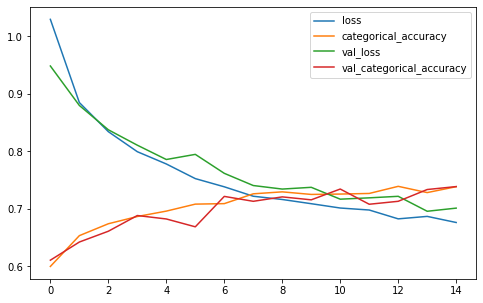

In [6]:
from matplotlib import pyplot as plt
from pandas import DataFrame
DataFrame(classifier.fit_result.history).plot(figsize=(8,5))
plt.show()